In [1]:
import pandas as pd
df = pd.read_csv('C:\Users\marcel.massa.LGE\Downloads\TD1.csv', sep=';', encoding='latin-1')
df.head()


,Texto,Sintoma
0,FOI REALIZADO A COMPRA DO CELULAR E O MESMO SU...,Heating
1,Dificuldade ao carregar. O carregador não cone...,Battery / No charging / Fast discharge
2,"O aparelho não está carregando, está totalment...",Battery / No charging / Fast discharge
3,olá. há alguns meses meu celular apresentou pr...,Battery / No charging / Fast discharge
4,"O CARREGADOR DÁ SINAL DE CONECTADO, POREM O AP...",Battery / No charging / Fast discharge


In [2]:
df = df[pd.notnull(df['Sintoma'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 0 to 659
Data columns (total 2 columns):
Texto      660 non-null object
Sintoma    660 non-null object
dtypes: object(2)
memory usage: 10.3+ KB


In [3]:
col = ['Texto', 'Sintoma']
df = df[col]

In [4]:
df.columns

Index([u'Texto', u'Sintoma'], dtype='object')

In [5]:
df.columns = ['Texto', 'Sintoma']
df['category_id'] = df['Sintoma'].factorize()[0]

from io import StringIO

category_id_df = df[['Sintoma', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Sintoma']].values)
df.head()

,Texto,Sintoma,category_id
0,FOI REALIZADO A COMPRA DO CELULAR E O MESMO SU...,Heating,0
1,Dificuldade ao carregar. O carregador não cone...,Battery / No charging / Fast discharge,1
2,"O aparelho não está carregando, está totalment...",Battery / No charging / Fast discharge,1
3,olá. há alguns meses meu celular apresentou pr...,Battery / No charging / Fast discharge,1
4,"O CARREGADOR DÁ SINAL DE CONECTADO, POREM O AP...",Battery / No charging / Fast discharge,1


In [6]:
import matplotlib.pyplot as plt

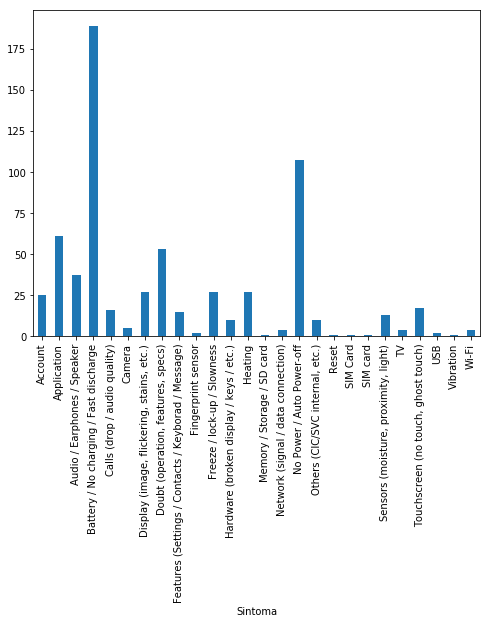

In [7]:
fig = plt.figure(figsize=(8,6))
df.groupby('Sintoma').Sintoma.count().plot.bar(ylim=0)
plt.show()

In [8]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords.words('portuguese'), strip_accents='unicode')

features = tfidf.fit_transform(df.Texto).toarray()
labels = df.category_id
features.shape

c:\python27\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'ate', u'eramos', u'estao', u'estavamos', u'estiveramos', u'estivessemos', u'foramos', u'fossemos', u'ha', u'hao', u'houveramos', u'houverao', u'houveriamos', u'houvessemos', u'ja', u'nao', u'sao', u'sera', u'serao', u'seriamos', u'so', u'tambem', u'tera', u'terao', u'teriamos', u'tinhamos', u'tiveramos', u'tivessemos', u'voce', u'voces'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(660, 823)

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

N = 3
for Sintoma, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Sintoma))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]).encode('utf-8')))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]).encode('utf-8')))

# 'Account':
  . Most correlated unigrams:
       . pedindo
       . recuperar
       . senha
  . Most correlated bigrams:
       . feito reset
       . recuperar senha
       . celular travado
# 'Application':
  . Most correlated unigrams:
       . app
       . aplicativos
       . propagandas
  . Most correlated bigrams:
       . retornar ligacao
       . apagar dados
       . whatsapp nao
# 'Audio / Earphones / Speaker':
  . Most correlated unigrams:
       . som
       . falante
       . ouvido
  . Most correlated bigrams:
       . aparelho audio
       . sai som
       . fone ouvido
# 'Battery / No charging / Fast discharge':
  . Most correlated unigrams:
       . descarrega
       . rapido
       . carrega
  . Most correlated bigrams:
       . nao segura
       . descarrega rapido
       . nao carrega
# 'Calls (drop / audio quality)':
  . Most correlated unigrams:
       . pessoa
       . mudo
       . microfone
  . Most correlated bigrams:
       . aparelho fica
       . cliente

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Texto'], df['Sintoma'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
print(clf.predict(count_vect.transform(["O aparelho esta com problemas a saida de son dele esta falalhando e por conta disso o celular esquenta quando vejo videio ou entao ouso musica ele falha e fica fazendo um barulho estranho"])))

[u'Battery / No charging / Fast discharge']


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.head()

c:\python27\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.347222
1,RandomForestClassifier,1,0.321168
2,RandomForestClassifier,2,0.356589
3,RandomForestClassifier,3,0.377953
4,RandomForestClassifier,4,0.398374


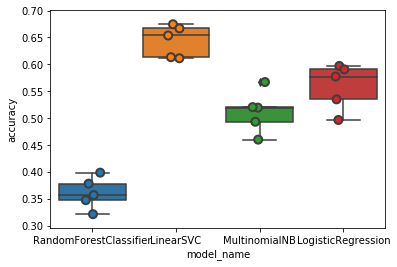

In [14]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.643776
LogisticRegression        0.559152
MultinomialNB             0.511909
RandomForestClassifier    0.360261
Name: accuracy, dtype: float64

In [16]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


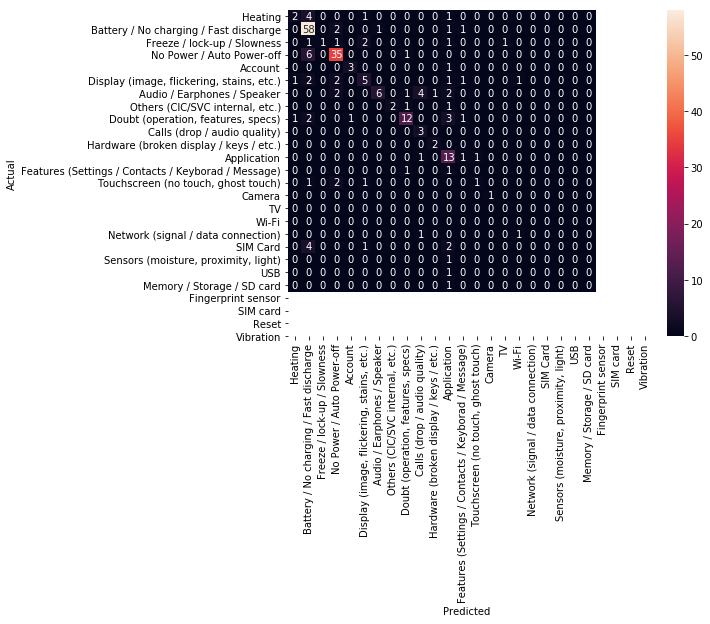

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Sintoma.values, yticklabels=category_id_df.Sintoma.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 4:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Sintoma', 'Texto']])
      print('')

IndexError: index 22 is out of bounds for axis 0 with size 22

In [19]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
from sklearn.feature_selection import chi2

N = 3
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams).encode('utf-8')))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams).encode('utf-8')))

# 'Account':
  . Top unigrams:
       . senha
       . pedindo
       . pede
  . Top bigrams:
       . celular travado
       . deu certo
       . vai verificar
# 'Application':
  . Top unigrams:
       . aplicativos
       . app
       . propagandas
  . Top bigrams:
       . retornar ligacao
       . realizado sucesso
       . caso nao
# 'Audio / Earphones / Speaker':
  . Top unigrams:
       . som
       . fazendo
       . fone
  . Top bigrams:
       . aparelho audio
       . sai som
       . nao escuta
# 'Battery / No charging / Fast discharge':
  . Top unigrams:
       . rapido
       . carrega
       . carga
  . Top bigrams:
       . aparelho descarrega
       . nao carrega
       . descarrega rapido
# 'Calls (drop / audio quality)':
  . Top unigrams:
       . pessoa
       . microfone
       . chamada
  . Top bigrams:
       . cliente orientado
       . aparelho fica
       . nao possivel
# 'Camera':
  . Top unigrams:
       . camera
       . abre
       . videos
  . Top bigrams

In [21]:
texts = ["Se desligando quando esquenta",
         "Aparelho esta travado desde das 06:00 da manhã,  e fica iniciando com informação de iniciando e  após isso com a mensagem  que android esta iniciando e  que não desligue.  Orientada a forçar a inicialização do aparelho. Procedimento efetuado com sucesso.",
         "Cliente relata que seu aparelho não esta saindo nenhum som, totalmente mudo, só funciona no fone de ouvido, restauração persiste com o problema. , 4E TECNOLOGIA LTDA/(41) 3022-7857/(41) 3322-0031/80230-100/Rua Desembargador WestPhalen 1172 Rebouças",
         "Cliente realizou reset de fábrica sem remover conta Google cadastrada.   **Informado que para ter acesso ao aparelho será necessário inserir conta existente anteriormente no produto**",
         "ligo o meu celular ele inicia , aparece o logo da LG e desliga sozinho.  **Orientada a conectar o aparelho no carregador** Cliente relata que o aparelho voltou a ligar e ele estava com 1% de bateria."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Se desligando quando esquenta"
  - Predicted as: 'Heating'

"Aparelho esta travado desde das 06:00 da manhã,  e fica iniciando com informação de iniciando e  após isso com a mensagem  que android esta iniciando e  que não desligue.  Orientada a forçar a inicialização do aparelho. Procedimento efetuado com sucesso."
  - Predicted as: 'Freeze / lock-up / Slowness'

"Cliente relata que seu aparelho não esta saindo nenhum som, totalmente mudo, só funciona no fone de ouvido, restauração persiste com o problema. , 4E TECNOLOGIA LTDA/(41) 3022-7857/(41) 3322-0031/80230-100/Rua Desembargador WestPhalen 1172 Rebouças"
  - Predicted as: 'Audio / Earphones / Speaker'

"Cliente realizou reset de fábrica sem remover conta Google cadastrada.   **Informado que para ter acesso ao aparelho será necessário inserir conta existente anteriormente no produto**"
  - Predicted as: 'Account'

"ligo o meu celular ele inicia , aparece o logo da LG e desliga sozinho.  **Orientada a conectar o aparelho no carrega

In [34]:
prediction_new = model.predict(tfidf.transform(["O aparelho esta com problemas a saida de son dele esta falalhando e por conta disso o celular esquenta quando vejo videio ou entao ouso musica ele falha e fica fazendo um barulho estranho"]))
print(prediction_new)

[6]


In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Sintoma'].unique()))

ValueError: Number of classes, 22, does not match size of target_names, 26. Try specifying the labels parameter

In [23]:
print(df['Sintoma'].unique())

[u'Heating' u'Battery / No charging / Fast discharge'
 u'Freeze / lock-up / Slowness' u'No Power / Auto Power-off' u'Account'
 u'Display (image, flickering, stains, etc.)'
 u'Audio / Earphones / Speaker' u'Others (CIC/SVC internal, etc.)'
 u'Doubt (operation, features, specs)' u'Calls (drop / audio quality)'
 u'Hardware (broken display / keys / etc.)' u'Application'
 u'Features (Settings / Contacts / Keyborad / Message)'
 u'Touchscreen (no touch, ghost touch)' u'Camera' u'TV' u'Wi-Fi'
 u'Network (signal / data connection)' u'SIM Card'
 u'Sensors (moisture, proximity, light)' u'USB'
 u'Memory / Storage / SD card' u'Fingerprint sensor' u'SIM card' u'Reset'
 u'Vibration']


In [24]:
tab_labels = [u'Heating', u'Battery / No charging / Fast discharge',
 u'Freeze / lock-up / Slowness', u'No Power / Auto Power-off', u'Account',
 u'Display (image, flickering, stains, etc.)',
 u'Audio / Earphones / Speaker', u'Others (CIC/SVC internal, etc.)',
 u'Doubt (operation, features, specs)', u'Calls (drop / audio quality)',
 u'Hardware (broken display / keys / etc.)', u'Application',
 u'Features (Settings / Contacts / Keyborad / Message)',
 u'Touchscreen (no touch, ghost touch)', u'Camera', u'TV', u'Wi-Fi',
 u'Network (signal / data connection)', u'SIM Card',
 u'Sensors (moisture, proximity, light)',
 u'USB', u'Memory / Storage / SD card', u'Fingerprint sensor', u'SIM card',
 u'Reset', u'Vibration']

In [25]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, labels=tab_labels, 
                                    target_names=df['Sintoma'].unique()))

                                                     precision    recall  f1-score   support

                                            Heating       0.00      0.00      0.00         0
             Battery / No charging / Fast discharge       0.00      0.00      0.00         0
                        Freeze / lock-up / Slowness       0.00      0.00      0.00         0
                          No Power / Auto Power-off       0.00      0.00      0.00         0
                                            Account       0.00      0.00      0.00         0
          Display (image, flickering, stains, etc.)       0.00      0.00      0.00         0
                        Audio / Earphones / Speaker       0.00      0.00      0.00         0
                    Others (CIC/SVC internal, etc.)       0.00      0.00      0.00         0
                 Doubt (operation, features, specs)       0.00      0.00      0.00         0
                       Calls (drop / audio quality)       0.00      0

c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [35]:
df_new = pd.read_csv('C:\Users\marcel.massa.LGE\Downloads\Test_data_1.csv', sep=';', encoding='latin-1')
df_new.head()

,Texto,Sintoma,Unnamed: 2
0,A tela do telefone apresenta cores diferentes ...,NaN,NaN
1,A TELA FICA TREMULA QUANDO TOCA NA TELA .,NaN,NaN
2,Área do cliente não é coberta pelo serviço LG...,NaN,NaN
3,Área do cliente não é coberta pelo serviço LG ...,NaN,NaN
4,tela nao liga,NaN,NaN


In [36]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 3 columns):
Texto         1666 non-null object
Sintoma       0 non-null float64
Unnamed: 2    0 non-null float64
dtypes: float64(2), object(1)
memory usage: 32.6+ KB


In [43]:
for count in range(5):
    print(df_new.Texto[count])
    prediction_new = model.predict(tfidf.transform(df_new.Texto[count]))
    print(prediction_new)

A tela do telefone apresenta cores diferentes do usual, foi olhada a configuração que está normal e apos restauração do sistema o problema persiste. O suporte a distancia do aparelho não foi dos melhores e a cidade não possui assistência técnica. 


ValueError: Iterable over raw text documents expected, string object received.

In [107]:
features_new = tfidf.transform(df_new.Texto)
features_new.shape

(1666, 1805)

In [45]:
texts_new = df_new.Texto
text_features_new = tfidf.transform(texts_new)
predictions_new = model.predict(text_features_new)
for text, predicted in zip(texts_new, predictions_new):
  print(u'"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"A tela do telefone apresenta cores diferentes do usual, foi olhada a configuração que está normal e apos restauração do sistema o problema persiste. O suporte a distancia do aparelho não foi dos melhores e a cidade não possui assistência técnica. "
  - Predicted as: 'Freeze / lock-up / Slowness'

"A TELA FICA TREMULA QUANDO TOCA NA TELA ."
  - Predicted as: 'Display (image, flickering, stains, etc.)'

" Área do cliente não é coberta pelo serviço LG Collect  enviado o e-mail Indicação de Assistência Técnica Autorizada."
  - Predicted as: 'Others (CIC/SVC internal, etc.)'

"Área do cliente não é coberta pelo serviço LG Collect  enviado o e-mail Indicação de Assistência Técnica Autorizada"
  - Predicted as: 'Others (CIC/SVC internal, etc.)'

"tela nao liga "
  - Predicted as: 'No Power / Auto Power-off'

"O celular começou a apresentar problema no carregador , não carregava na mesma eficiência que antes , depois passou a demorar para carregar em todos os carregadores. "
  - Predict

"Cliente solicita ajuda suporte  para seu aparelho que esta chiando, informei que tem que fazer reset, cliente vai pensar melhor e ligara mais tarde se resolver fazer"
  - Predicted as: 'Doubt (operation, features, specs)'

"Cliente solicita ajuda suporte para seu aparelho que esta com problemas no carregamento, SMS enviado com sucesso"
  - Predicted as: 'Doubt (operation, features, specs)'

"Cliente solicita informação para bloquear seu aparelho, informei que tem que entrar em contato com a operadora e informar o IMEI"
  - Predicted as: 'Doubt (operation, features, specs)'

"alem do touch, a entrada do carregador tambem esta com mal funcionamento e tampa traseira descascou."
  - Predicted as: 'Touchscreen (no touch, ghost touch)'

"Aparelho não reconhece o sim card, orientei ao mesmo a fazer a pesquisa de rede, o mesmo ira retornar caso não resolva"
  - Predicted as: 'Application'

"O celular esta travado na tela inicial ."
  - Predicted as: 'Account'

"nao ta ligando"
  - Predicted a


"LGCBA Informações sobre horário e endereço. Orientado."
  - Predicted as: 'Doubt (operation, features, specs)'

"TOUCH SCREEN APAGOU, NÃO ACENDE, NÃO CONSEGUE VER NADA."
  - Predicted as: 'Touchscreen (no touch, ghost touch)'

"Cliente em contato pede ajuda para colocar a função vibrar o despertador. -feito manuseio :, para ativar a função " vibrar ao tocar alarme"."
  - Predicted as: 'Doubt (operation, features, specs)'

"Cliente solicita informações de como rastrear aparelho perdido.  **Enviado SMS com passo a passo do rastreio**"
  - Predicted as: 'Doubt (operation, features, specs)'

"Cliente conseguiu recuperar seu aparelho e queria desbloquear, orientado a fazer o reset."
  - Predicted as: 'Application'

"Lojista entra em contato pois cliente gostaria de saber sobre a a ordem serviço ,informada que houve perda de garantia por perda de garantia "
  - Predicted as: 'Doubt (operation, features, specs)'

"Coloco para carregar tem vez que carrega 20% e tem dia que fica o dia todo co

"O celular não quer ligar.   [TS+131304195950241]  Linha / Produto / Sintoma / Sub-sintoma Celular/Celular/Tablet / Energia / Não Liga  "
  - Predicted as: 'No Power / Auto Power-off'

"Cliente informa que carregador do aparelho não está funcionando, indicada ASC. CELULAR SYSTEM LTDA/(13) 3289-2005 / 3289-7600/(13) 99117-4160/11060-002/AV ANA COSTA 476 GONZAGA"
  - Predicted as: 'Battery / No charging / Fast discharge'

"nao conecta a torre nao tem sinal com nenhum chip "
  - Predicted as: 'Network (signal / data connection)'

"Aparelho não carrega. , OPTITEL ELETRONICA E COMUNICACOES LTDA/(21) 2532-8723/(21)  2532-8682/20040-006/AV RIO BRANCO 151 CENTRO"
  - Predicted as: 'Battery / No charging / Fast discharge'

"Tela branca com quadriculado não liga"
  - Predicted as: 'No Power / Auto Power-off'

"Não apresenta imagem"
  - Predicted as: 'Display (image, flickering, stains, etc.)'

"Meu celular não quer ligar.   [TS+131304192149926]  Linha / Produto / Sintoma / Sub-sintoma Celular/Ce

In [49]:
df_new.Sintoma = predictions_new
df_new.head()

,Texto,Sintoma,Unnamed: 2
0,A tela do telefone apresenta cores diferentes ...,2,NaN
1,A TELA FICA TREMULA QUANDO TOCA NA TELA .,5,NaN
2,Área do cliente não é coberta pelo serviço LG...,7,NaN
3,Área do cliente não é coberta pelo serviço LG ...,7,NaN
4,tela nao liga,3,NaN


In [52]:
for count in range (df_new.shape[0]):
    df_new.Sintoma[count] = id_to_category[predictions_new[count]]
df_new.head()

c:\python27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Texto,Sintoma,Unnamed: 2
0,A tela do telefone apresenta cores diferentes ...,Freeze / lock-up / Slowness,NaN
1,A TELA FICA TREMULA QUANDO TOCA NA TELA .,"Display (image, flickering, stains, etc.)",NaN
2,Área do cliente não é coberta pelo serviço LG...,"Others (CIC/SVC internal, etc.)",NaN
3,Área do cliente não é coberta pelo serviço LG ...,"Others (CIC/SVC internal, etc.)",NaN
4,tela nao liga,No Power / Auto Power-off,NaN


In [55]:
df_new.to_excel('C:\Users\marcel.massa.LGE\Downloads\Test_data_1_PREDICTED.xlsx')